In [1]:
import pandas as pd
import numpy as np
import psycopg2 as pg
import matplotlib.pyplot as plt
import scipy.spatial.distance as distance
from sklearn.cluster import KMeans
from dotenv import dotenv_values
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler
import matplotlib.patches as mpatches
import ast


### Retrieve DF From Postgres Databse

In [2]:
# Load env Variables
config = dotenv_values("../.env")
postgres_user = config["postgres_user"]
postgres_pw = config["postgres_pw"]
# Specify Data Column Types
dtypes = {
    "id" : int,
    "vector" : object
}
# Connect to postgres and store data in df
engine = pg.connect(f"dbname='project_vector' user={postgres_user} host='127.0.0.1' port='5432' password={postgres_user}")
df = pd.read_sql('select * from my_vectors', columns=["ID" , "vector"] ,con=engine, dtype=dtypes)
df.columns
engine.close()


/tmp/ipykernel_6688/462947155.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql('select * from my_vectors', columns=["ID" , "vector"] ,con=engine, dtype=dtypes)


### UMAP

In [3]:

vector = df["vector"][0]
# String to List of Floats
df["vector"] = df["vector"].apply(lambda x: ast.literal_eval(x))


In [4]:
df

,id,vector
0,1,"[0.803, 0.624, 7, -6.764, 0, 0.0477, 0.451, 0...."
1,2,"[0.762, 0.703, 10, -7.951, 0, 0.306, 0.206, 0,..."
2,3,"[0.261, 0.0149, 1, -27.528, 1, 0.0419, 0.992, ..."
3,4,"[0.722, 0.736, 3, -6.994, 0, 0.0585, 0.431, 1...."
4,5,"[0.787, 0.572, 1, -7.516, 1, 0.222, 0.145, 0, ..."
...,...,...
190,191,"[0.166, 0.0551, 9, -19.494, 0, 0.052, 0.976, 0..."
191,192,"[0.862, 0.624, 3, -11.63, 1, 0.0565, 0.0192, 0..."
192,193,"[0.499, 0.351, 9, -11.509, 0, 0.0448, 0.951, 9..."
193,194,"[0.574, 0.729, 10, -5.838, 0, 0.0965, 0.0406, ..."


In [5]:
# Expand vector to columns
df_vectors = pd.DataFrame(df["vector"].to_list() , columns=[ "danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "duration_ms", "time_signature", "liked"])

# Scale columns
df_vectors["duration_ms"] = df_vectors["duration_ms"]/ df_vectors["duration_ms"].max()
df_vectors["tempo"] = df_vectors["tempo"]/ df_vectors["tempo"].max()
df_vectors

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,liked
0,0.803,0.6240,7,-6.764,0,0.0477,0.4510,0.000734,0.1000,0.6280,0.533049,0.464771,4,0
1,0.762,0.7030,10,-7.951,0,0.3060,0.2060,0.000000,0.0912,0.5190,0.840549,0.377248,4,1
2,0.261,0.0149,1,-27.528,1,0.0419,0.9920,0.897000,0.1020,0.0382,0.418227,0.438006,4,0
3,0.722,0.7360,3,-6.994,0,0.0585,0.4310,0.000001,0.1230,0.5820,0.499122,0.318858,4,1
4,0.787,0.5720,1,-7.516,1,0.2220,0.1450,0.000000,0.0753,0.6470,0.861589,0.273824,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,0.166,0.0551,9,-19.494,0,0.0520,0.9760,0.635000,0.1190,0.1430,0.981004,0.315195,3,0
191,0.862,0.6240,3,-11.630,1,0.0565,0.0192,0.000153,0.0465,0.8820,0.693728,0.388026,4,0
192,0.499,0.3510,9,-11.509,0,0.0448,0.9510,0.000099,0.1180,0.6160,0.503588,0.360107,4,0
193,0.574,0.7290,10,-5.838,0,0.0965,0.0406,0.000004,0.1940,0.4130,0.614027,0.290347,5,1


In [6]:

rd = umap.UMAP()
scaled_vectors = StandardScaler().fit_transform(df_vectors.values)

/home/anton/Anton/Studium/DHBW /Semester_5/Datamanagement/Projekt/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


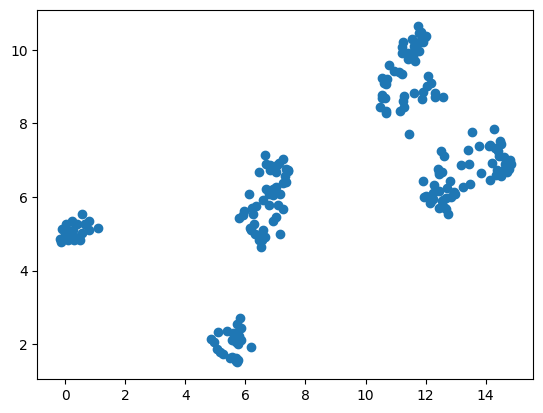

In [7]:
# First UMAP - Algorithm
embedding = rd.fit_transform(scaled_vectors)
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
)

In [8]:
# Show UMAP based on Neighbour Size etc 
# Print every avrg distance
def draw_umap(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(scaled_vectors);
    fig = plt.figure()
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], range(len(u)))
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1])
        print(np.array(distance.pdist(u)).mean())
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2], s=100)
    plt.title(title, fontsize=18)

/home/anton/Anton/Studium/DHBW /Semester_5/Datamanagement/Projekt/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


14.491261679792474
7.71881792916004
8.234888866702326


/home/anton/Anton/Studium/DHBW /Semester_5/Datamanagement/Projekt/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/anton/Anton/Studium/DHBW /Semester_5/Datamanagement/Projekt/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/anton/Anton/Studium/DHBW /Semester_5/Datamanagement/Projekt/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


6.175588359634461
6.399049446409277


/home/anton/Anton/Studium/DHBW /Semester_5/Datamanagement/Projekt/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/anton/Anton/Studium/DHBW /Semester_5/Datamanagement/Projekt/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


4.733577955859967
4.0371557296839145


/home/anton/Anton/Studium/DHBW /Semester_5/Datamanagement/Projekt/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


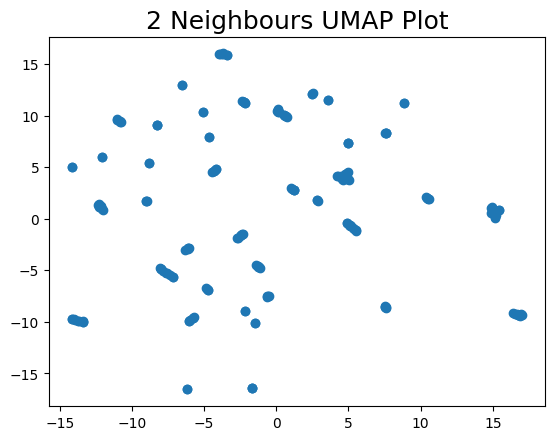

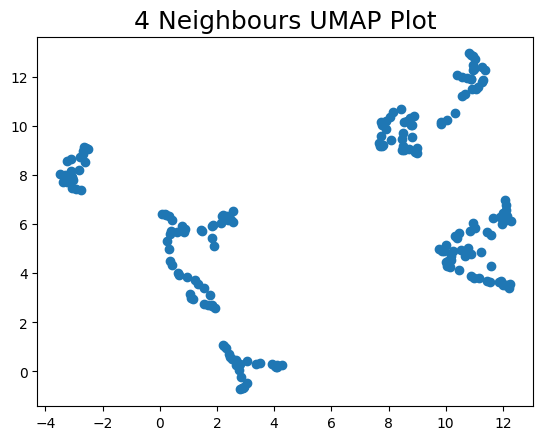

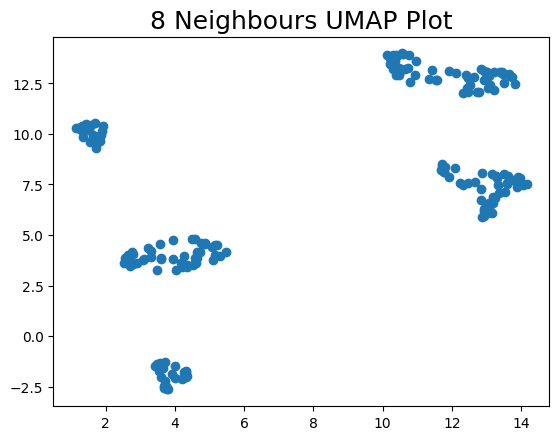

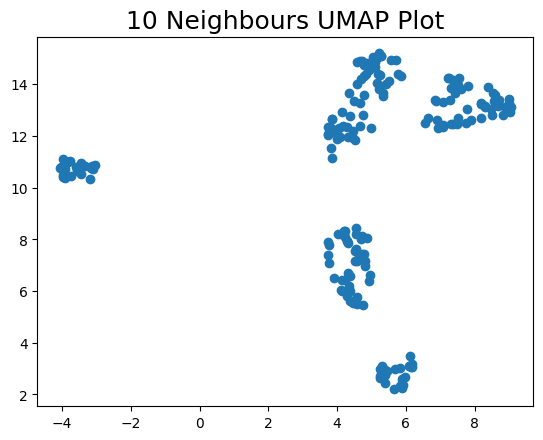

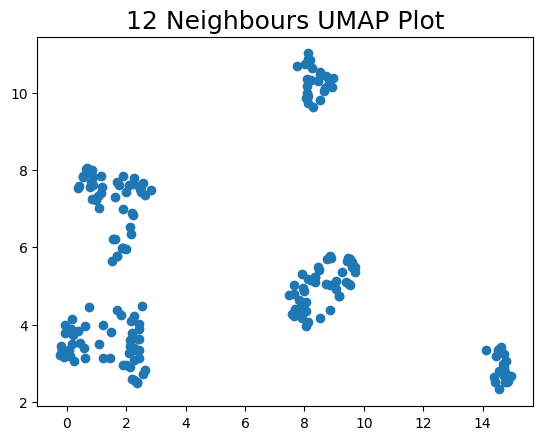

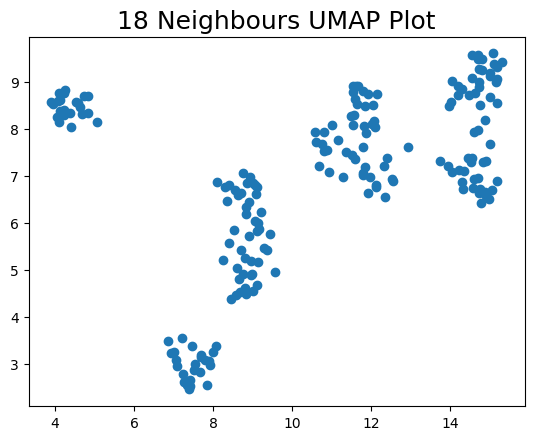

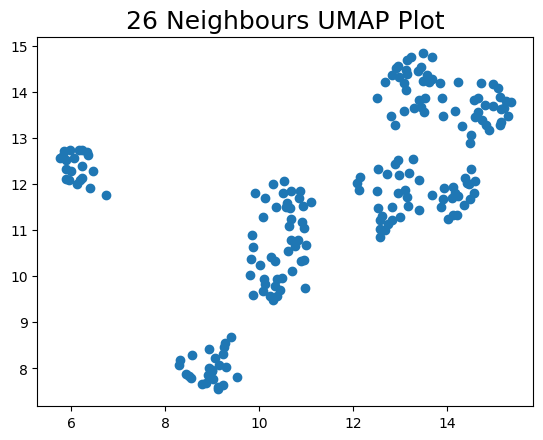

In [9]:
# Increase  Neighbour Sizes
for neigbours in [2,4,8,10,12,18,26]:
    draw_umap(n_neighbors=neigbours, min_dist=0.1, n_components=2, metric='euclidean', title=f'{neigbours} Neighbours UMAP Plot')

In [10]:
# Funciton for avergae distance
def avrg_distance_umap(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean') -> float:
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(scaled_vectors);
    return np.array(distance.pdist(u)).mean()

/home/anton/Anton/Studium/DHBW /Semester_5/Datamanagement/Projekt/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/anton/Anton/Studium/DHBW /Semester_5/Datamanagement/Projekt/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/anton/Anton/Studium/DHBW /Semester_5/Datamanagement/Projekt/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/anton/Anton/Studium/DHBW /Semester_5/Datamanagement/Projekt/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.

Text(0, 0.5, 'Average Distance')

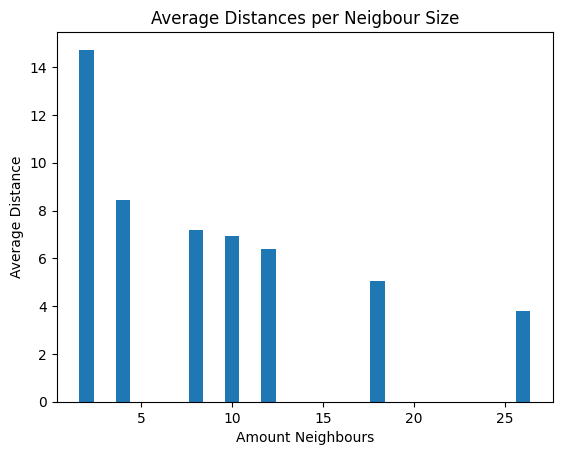

In [11]:
# Print average distances for each point and neighbors size
neighbours = [2,4,8,10,12,18,26]
average_distances : list[float] = [] 
for neigbours in neighbours:
    average_distances.append(avrg_distance_umap(n_neighbors=neigbours, min_dist=0.1, n_components=2, metric='euclidean'))

plt.bar(neighbours , average_distances)
plt.title("Average Distances per Neigbour Size")
plt.xlabel("Amount Neighbours")
plt.ylabel("Average Distance")

### Perform Kmeans 

In [12]:
fit = umap.UMAP(
    n_neighbors=10,
    min_dist=0.1,
    n_components=2,
    metric="euclidean"
)
u = fit.fit_transform(scaled_vectors)

/home/anton/Anton/Studium/DHBW /Semester_5/Datamanagement/Projekt/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


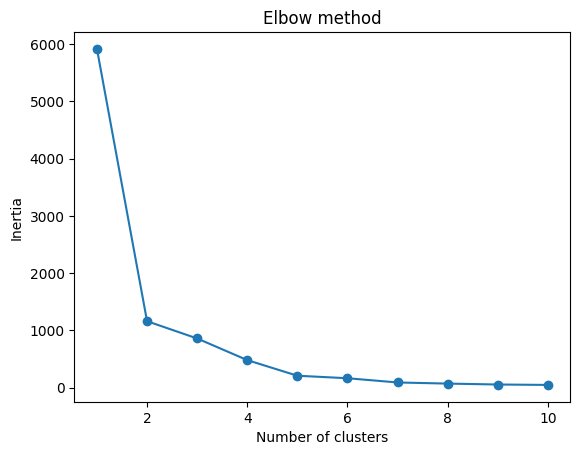

In [13]:
# Ellbow Method
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(u)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show() 

In [14]:
# Cluster size 5 with k-means
kmeans = KMeans(n_clusters=5, random_state=0, n_init="auto").fit(u)
kmeans.labels_


array([2, 3, 0, 3, 1, 1, 3, 1, 2, 1, 4, 1, 4, 1, 1, 2, 1, 2, 1, 1, 1, 2,
       3, 1, 3, 1, 3, 3, 1, 1, 3, 3, 4, 3, 2, 0, 2, 4, 2, 3, 4, 3, 3, 3,
       4, 4, 2, 1, 0, 4, 3, 1, 3, 2, 4, 1, 3, 1, 0, 4, 2, 3, 0, 3, 4, 3,
       3, 2, 1, 1, 1, 1, 3, 2, 1, 4, 4, 1, 3, 3, 1, 2, 3, 0, 1, 2, 0, 4,
       2, 2, 3, 2, 2, 2, 1, 2, 3, 2, 1, 1, 2, 1, 3, 4, 1, 2, 4, 0, 2, 1,
       0, 3, 1, 0, 4, 4, 2, 2, 1, 3, 3, 2, 3, 3, 1, 1, 4, 2, 2, 0, 2, 2,
       4, 1, 3, 0, 1, 2, 0, 1, 1, 1, 0, 2, 4, 2, 4, 3, 3, 1, 3, 2, 1, 4,
       2, 1, 3, 2, 0, 0, 3, 1, 3, 3, 2, 1, 1, 0, 0, 1, 0, 0, 1, 3, 2, 2,
       0, 1, 1, 1, 2, 1, 3, 4, 2, 2, 1, 3, 3, 4, 0, 2, 2, 3, 1],
      dtype=int32)

Text(0.5, 1.0, 'KMeans Cluster for UMAP')

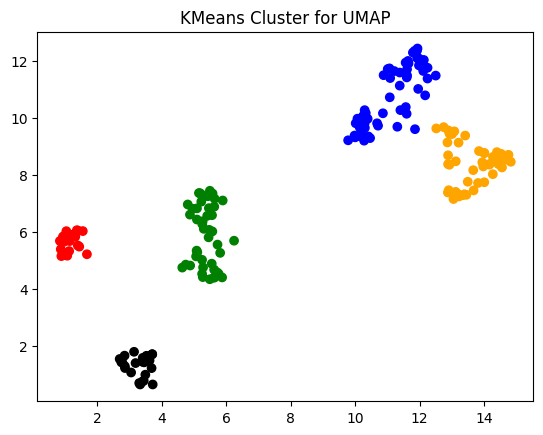

In [15]:
# Plot Cluster with UMAP
fig = plt.figure()
ax = fig.add_subplot(111)

colors = kmeans.labels_
colors = colors.astype(str)
colors[colors == "0" ] = "red"
colors[colors == "1" ] = "blue"
colors[colors == "2" ] = "green"
colors[colors == "3" ] = "orange"
colors[colors == "4" ] = "black"


red_patch = mpatches.Patch(color='red', label='klassisch')
blue_patch = mpatches.Patch(color='blue', label='Pop')
green_patch = mpatches.Patch(color='green', label='Soft-Rock')
orange_patch = mpatches.Patch(color='orange', label='Rap')
black_patch = mpatches.Patch(color='black', label='Rock')



ax.scatter(u[:,0], u[:,1], c=colors)
ax.set_title("KMeans Cluster for UMAP")
#ax.legend(handles=[red_patch , blue_patch, green_patch, orange_patch , black_patch])

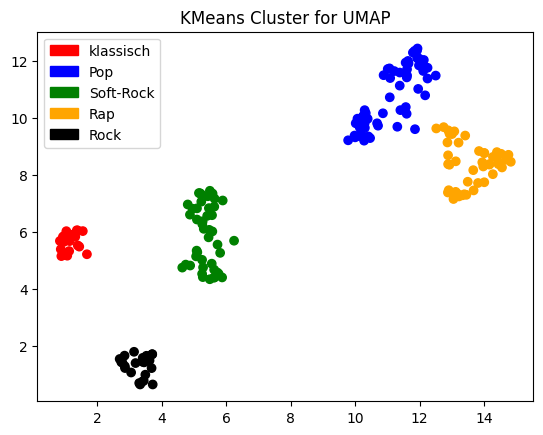

In [16]:
# Plot Cluster with UMAP and Legend

fig = plt.figure()
ax = fig.add_subplot(111)

colors = kmeans.labels_
colors = colors.astype(str)
colors[colors == "0" ] = "red"
colors[colors == "1" ] = "blue"
colors[colors == "2" ] = "green"
colors[colors == "3" ] = "orange"
colors[colors == "4" ] = "black"


red_patch = mpatches.Patch(color='red', label='klassisch')
blue_patch = mpatches.Patch(color='blue', label='Pop')
green_patch = mpatches.Patch(color='green', label='Soft-Rock')
orange_patch = mpatches.Patch(color='orange', label='Rap')
black_patch = mpatches.Patch(color='black', label='Rock')


#ax = fig.add_subplot( projection='3d')
ax.scatter(u[:,0], u[:,1],  c=colors)
ax.set_title("KMeans Cluster for UMAP")
ax.legend(handles=[red_patch , blue_patch, green_patch, orange_patch , black_patch])

/home/anton/Anton/Studium/DHBW /Semester_5/Datamanagement/Projekt/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


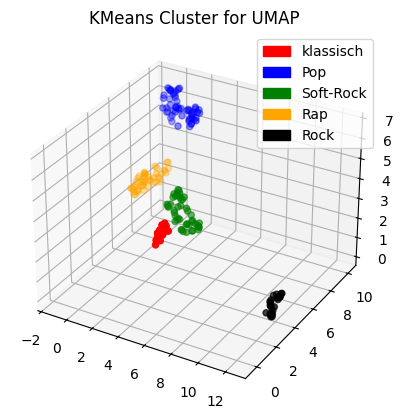

In [17]:
# 3 dimensional plot
fit = umap.UMAP(
    n_neighbors=10,
    min_dist=0.1,
    n_components=3,
    metric="euclidean"
)
u = fit.fit_transform(scaled_vectors)

fig = plt.figure()

colors = kmeans.labels_
colors = colors.astype(str)
colors[colors == "0" ] = "red"
colors[colors == "1" ] = "blue"
colors[colors == "2" ] = "green"
colors[colors == "3" ] = "orange"
colors[colors == "4" ] = "black"


red_patch = mpatches.Patch(color='red', label='klassisch')
blue_patch = mpatches.Patch(color='blue', label='Pop')
green_patch = mpatches.Patch(color='green', label='Soft-Rock')
orange_patch = mpatches.Patch(color='orange', label='Rap')
black_patch = mpatches.Patch(color='black', label='Rock')


ax = fig.add_subplot( projection='3d')
ax.scatter(u[:,0], u[:,1], u[:,2], s=20 ,c=colors)
ax.set_title("KMeans Cluster for UMAP")
ax.legend(handles=[red_patch , blue_patch, green_patch, orange_patch , black_patch])


### Craete Table an Save Data

In [19]:
# Connecto to database on localhost
# Datenmodell ist hier nicht optimal, aber fuer die Uebersichtlichkeit wird einfach eine separate Tabelle erstellt fuer t-SNE und UMAP Classes
conn = pg.connect(
    host="localhost", database="project_vector", user=postgres_user, password=postgres_pw
)
cur = conn.cursor()
# Create Table for UMAP Classes
cur.execute(
    f"""
    CREATE TABLE IF NOT EXISTS umap_classes (
        id SERIAL PRIMARY KEY REFERENCES public.my_vectors(id) ON DELETE CASCADE,
        class INTEGER NOT NULL
    )
"""
)
conn.commit()
cur.execute("delete from umap_classes")
conn.commit()


classes = [(int(class_),) for class_ in kmeans.labels_]  
cur.executemany("INSERT INTO umap_classes (class) VALUES (%s)", classes)

conn.commit()
cur.close()
conn.close()

print("Daten erfolgreich gespeichert!")


Daten erfolgreich gespeichert!
